In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import kagglehub
from sklearn.metrics import accuracy_score

from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from torch.utils.data import DataLoader
from torchvision import transforms

# EDA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [3]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")+"\\raw-img"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matej\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


Animals type 

In [4]:
clases = os.listdir(path)
print(clases)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Num of photos in each folder

In [5]:
print(f"{'Class Name':<20} | {'Count'}")
print("-" * 30)
for cl in clases:
    folder_path = os.path.join(path, cl)
    count = len(os.listdir(folder_path))
    print(f"{cl:<20} | {count}")

Class Name           | Count
------------------------------
cane                 | 4863
cavallo              | 2623
elefante             | 1446
farfalla             | 2112
gallina              | 3098
gatto                | 1668
mucca                | 1866
pecora               | 1820
ragno                | 4821
scoiattolo           | 1862


See what we have in dataset

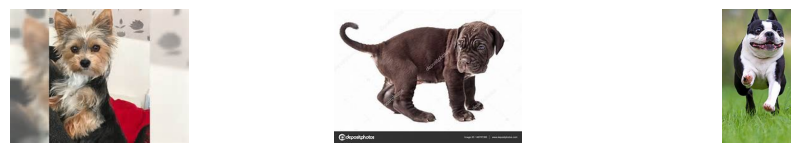

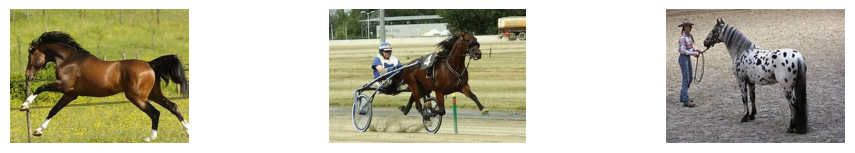

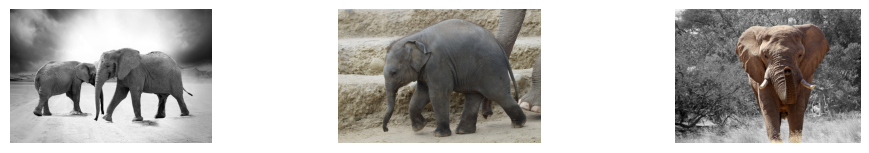

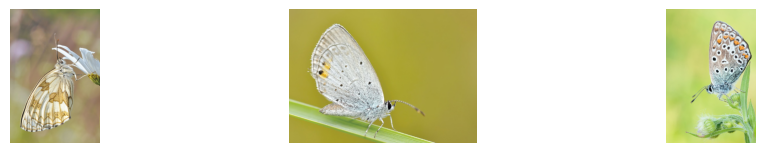

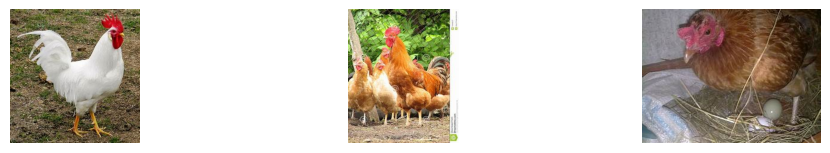

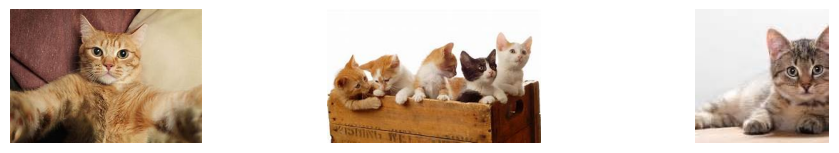

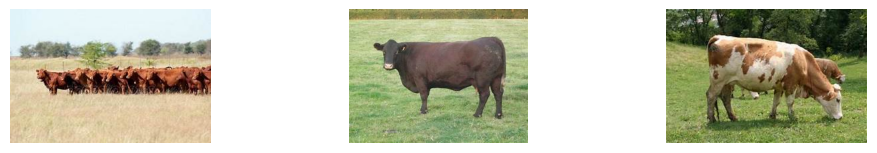

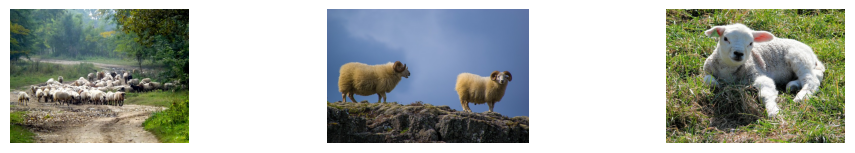

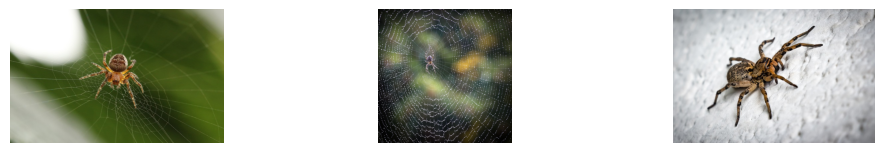

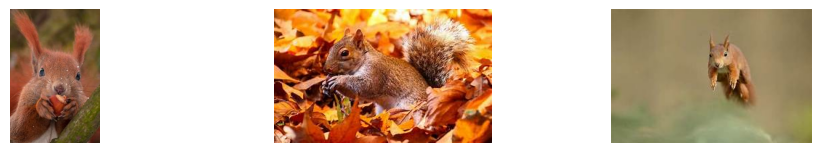

In [6]:
for cl in clases:
    n=3
    plt.figure(figsize=(12, 8))
    a = path+"\\"+cl
    imgs = os.listdir(a)
    i=1
    for _ in range(n):
        img_path = os.path.join(a, imgs[_])
        img = Image.open(img_path)

        plt.subplot(4, n, i)
        plt.imshow(img)
        plt.axis("off")
        i += 1

Analyze avg size

In [7]:
print(f"{'Class':<20} | {'Min W':<6} | {'Max W':<6} | {'Avg W':<8} | {'Min H':<6} | {'Max H':<6} | {'Avg H':<8}")
print("-" * 80)

# Ensure unique classes and sort them
unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = os.path.join(path, cl)
    widths = []
    heights = []
    
    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    # Get all images in the class folder
    try:
        imgs = os.listdir(folder_path)
    except Exception:
        continue
    
    for im_name in imgs:
        img_path = os.path.join(folder_path, im_name)
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            # print(f"Error reading {img_path}: {e}")
            continue
            
    if widths and heights:
        min_w = min(widths)
        max_w = max(widths)
        avg_w = sum(widths) / len(widths)
        
        min_h = min(heights)
        max_h = max(heights)
        avg_h = sum(heights) / len(heights)
        
        print(f"{cl:<20} | {min_w:<6} | {max_w:<6} | {avg_w:<8.1f} | {min_h:<6} | {max_h:<6} | {avg_h:<8.1f}")
    else:
        print(f"{cl:<20} | No images found or error reading images")

Class                | Min W  | Max W  | Avg W    | Min H  | Max H  | Avg H   
--------------------------------------------------------------------------------
cane                 | 109    | 300    | 283.6    | 101    | 300    | 241.1   
cane                 | 109    | 300    | 283.6    | 101    | 300    | 241.1   
cavallo              | 60     | 300    | 287.9    | 57     | 300    | 233.5   
elefante             | 189    | 640    | 377.6    | 115    | 640    | 274.9   
cavallo              | 60     | 300    | 287.9    | 57     | 300    | 233.5   
elefante             | 189    | 640    | 377.6    | 115    | 640    | 274.9   
farfalla             | 65     | 640    | 364.5    | 64     | 640    | 280.4   
farfalla             | 65     | 640    | 364.5    | 64     | 640    | 280.4   
gallina              | 82     | 300    | 288.3    | 95     | 300    | 239.4   
gallina              | 82     | 300    | 288.3    | 95     | 300    | 239.4   
gatto                | 107    | 6720   | 473.2    

In [8]:
# Analyze Image Channels
modes = {}
channels_count = {}

print("Analyzing image modes and channels")
for cl in clases:
    folder = os.path.join(path, cl)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                # Count modes (RGB, L, CMYK, etc.)
                modes[img.mode] = modes.get(img.mode, 0) + 1
                # Count channels
                c = len(img.getbands())
                channels_count[c] = channels_count.get(c, 0) + 1
        except:
            pass

print("Image Modes:", modes)
print("Channel Counts:", channels_count)

if 1 in channels_count or 4 in channels_count:
    print("\nNote: Dataset contains images with different channel counts.")
    print("We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.")
else:
    print("\nAll images are already 3 channels (RGB).")

Analyzing image modes and channels
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.


Analyze if RGB images are truly colorful or grayscale-like

In [9]:
# Analyze color distribution in images
# Check if RGB images are truly colorful or essentially grayscale

import numpy as np

def analyze_color_info(img):
    """
    Analyze if an image is truly colorful or grayscale-like.
    Returns metrics about color saturation and channel differences.
    """
    img_array = np.array(img.convert("RGB"))
    
    # Calculate channel-wise statistics
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
    
    # Check if channels are similar (grayscale-like)
    # If R ≈ G ≈ B for all pixels, image is grayscale
    rg_diff = np.abs(r.astype(float) - g.astype(float)).mean()
    rb_diff = np.abs(r.astype(float) - b.astype(float)).mean()
    gb_diff = np.abs(g.astype(float) - b.astype(float)).mean()
    
    avg_channel_diff = (rg_diff + rb_diff + gb_diff) / 3
    
    # Calculate color saturation using HSV-like approach
    max_channel = np.maximum(np.maximum(r, g), b).astype(float)
    min_channel = np.minimum(np.minimum(r, g), b).astype(float)
    
    # Saturation: difference between max and min channel
    saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)
    avg_saturation = saturation.mean()
    
    return avg_channel_diff, avg_saturation

print("Analyzing color characteristics per class...")
print(f"{'Class':<20} | {'Colorful':<10} | {'Grayscale-like':<15} | {'Avg Channel Diff':<18} | {'Avg Saturation':<15}")
print("-" * 90)

unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = os.path.join(path, cl)
    
    if not os.path.isdir(folder_path):
        continue
    
    colorful_count = 0
    grayscale_like_count = 0
    total_channel_diff = 0
    total_saturation = 0
    valid_images = 0
    
    imgs = os.listdir(folder_path)
    
    for im_name in imgs:
        img_path = os.path.join(folder_path, im_name)
        try:
            with Image.open(img_path) as im:
                channel_diff, saturation = analyze_color_info(im)
                total_channel_diff += channel_diff
                total_saturation += saturation
                valid_images += 1
                
                # Threshold: if avg channel difference < 5, consider grayscale-like
                if channel_diff < 5:
                    grayscale_like_count += 1
                else:
                    colorful_count += 1
        except Exception:
            continue
    
    if valid_images > 0:
        avg_diff = total_channel_diff / valid_images
        avg_sat = total_saturation / valid_images
        print(f"{cl:<20} | {colorful_count:<10} | {grayscale_like_count:<15} | {avg_diff:<18.2f} | {avg_sat:<15.4f}")

print("\nNote: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)")
print("Saturation: 0 = no color, 1 = fully saturated")

Analyzing color characteristics per class...
Class                | Colorful   | Grayscale-like  | Avg Channel Diff   | Avg Saturation 
------------------------------------------------------------------------------------------


C:\Users\matej\AppData\Local\Temp\ipykernel_13380\2913051640.py:29: RuntimeWarning: invalid value encountered in divide
  saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)


cane                 | 4663       | 200             | 24.83              | 0.3060         
cavallo              | 2566       | 57              | 25.28              | 0.3236         
cavallo              | 2566       | 57              | 25.28              | 0.3236         
elefante             | 1381       | 65              | 23.85              | 0.2933         
elefante             | 1381       | 65              | 23.85              | 0.2933         
farfalla             | 2083       | 29              | 37.49              | 0.4510         
farfalla             | 2083       | 29              | 37.49              | 0.4510         
gallina              | 3050       | 48              | 24.45              | 0.3087         
gallina              | 3050       | 48              | 24.45              | 0.3087         
gatto                | 1514       | 154             | 21.09              | 0.2663         
gatto                | 1514       | 154             | 21.09              | 0.2663         

In [10]:
files = []
labels = []
class_names = sorted(os.listdir(path))

class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Loading dataset...")
for cl in clases:
    a = path+"\\"+cl
    # Verify folder exists
    if not os.path.isdir(a):
        continue
        
    for img in os.listdir(a):
        files.append(os.path.join(a, img))
        labels.append(class_to_idx[cl])

print(f"Total images loaded: {len(files)}")
print(f"Total classes: {len(class_names)}")
print(f"Class mapping: {class_to_idx}")

Loading dataset...
Total images loaded: 26179
Total classes: 10
Class mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [11]:
print("Splitting dataset into Train and Test sets...")
train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels,
    test_size=0.2,
    stratify=labels,
    shuffle=True,
    random_state=42
)

print(f"Training samples: {len(train_files)}")
print(f"Testing samples: {len(test_files)}")

Splitting dataset into Train and Test sets...
Training samples: 20943
Testing samples: 5236


In [12]:
#Budeme vyuzivat accuracy a f1

In [13]:
# Define training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels (R, G, B)
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.RandomHorizontalFlip(p=0.5),        # Data Augmentation: Flip
    transforms.RandomRotation(5),                  # Data Augmentation: Rotate
    transforms.ColorJitter(                        # Data Augmentation: Color
        brightness=0.15,
        contrast=0.15
    ),
    transforms.ToTensor(),                         # Convert to Tensor (0-1 range)
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
print("Training transforms defined.")

Training transforms defined.


Visualizing Training Augmentations:


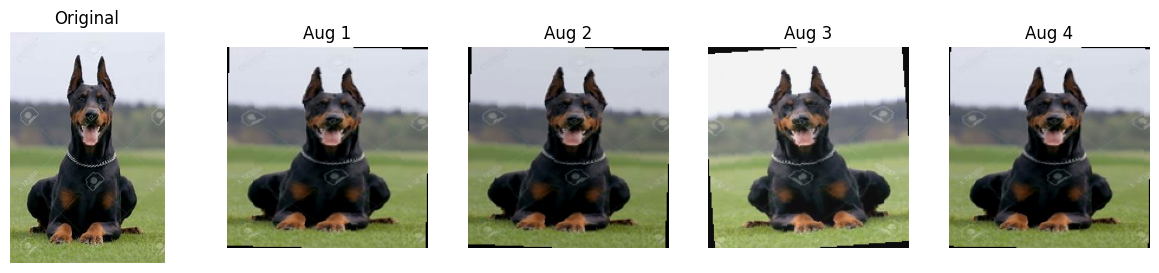

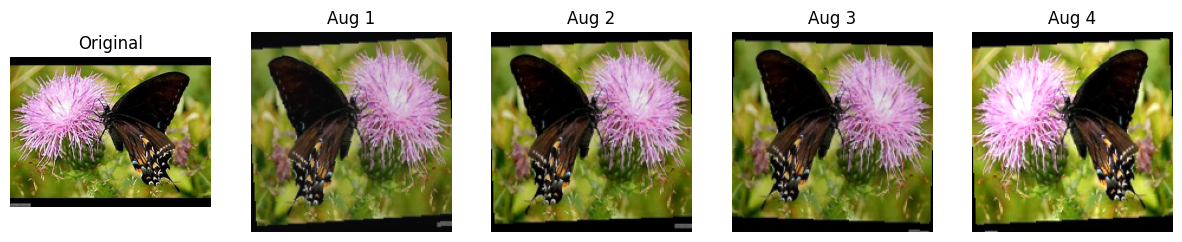

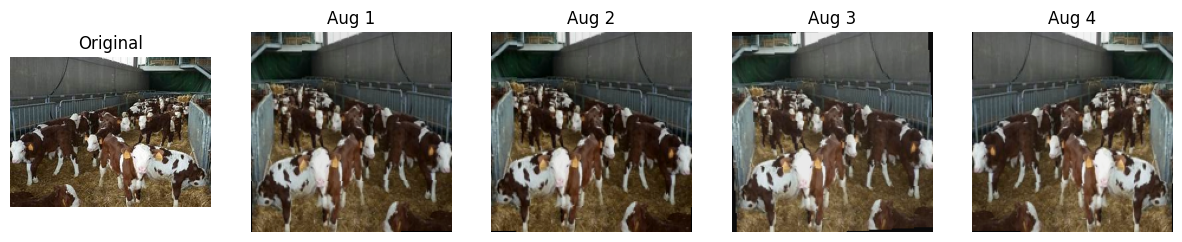

In [14]:
# Visualization of Augmentations
import numpy as np
import random

def visualize_augmentations(files, transform, n_samples=3):
    """
    Visualizes original images and their augmented versions.
    """
    # Select random files
    sample_files = random.sample(files, n_samples)
    
    for img_path in sample_files:
        # Load original
        original_img = Image.open(img_path)
        
        # Apply transform multiple times to see variations
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        
        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        for i in range(1, 5):
            # Apply transform
            aug_tensor = transform(original_img)
            
            # Un-normalize and convert to numpy for display
            # Using simple 0.5 mean/std
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            aug_img = std * aug_img + mean
            aug_img = np.clip(aug_img, 0, 1)
            
            axes[i].imshow(aug_img)
            axes[i].set_title(f"Aug {i}")
            axes[i].axis('off')
        plt.show()

print("Visualizing Training Augmentations:")
visualize_augmentations(train_files, train_transform)

In [15]:
# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.ToTensor(),                         # Convert to Tensor
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
print("Test transforms defined.")

Test transforms defined.


In [16]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.labels[idx]

# Initialize Datasets
print("Initializing Datasets...")
train_dataset = AnimalDataset(train_files, train_labels, transform=train_transform)
test_dataset = AnimalDataset(test_files, test_labels, transform=test_transform)

# Initialize DataLoaders
BATCH_SIZE = 32
print(f"Initializing DataLoaders with batch size {BATCH_SIZE}...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data preparation complete.")

Initializing Datasets...
Initializing DataLoaders with batch size 32...
Data preparation complete.


Visualizing samples from Test Dataset (Preprocessed)...


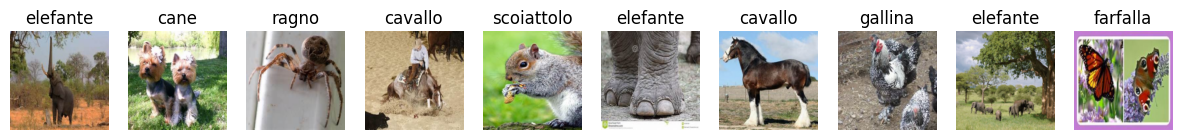

In [17]:
# Visualize Test Data
print("Visualizing samples from Test Dataset (Preprocessed)...")

def visualize_dataset_samples(dataset, class_names, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)
    
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Denormalize for visualization
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
        img_display = image.permute(1, 2, 0).numpy()
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    
    plt.show()

visualize_dataset_samples(test_dataset, class_names, 10)

# CNN Model Architecture

In [18]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalCNN, self).__init__()
        
        # Simple CNN: 3 conv blocks
        # Input: 3 x 170 x 170
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Used after each conv
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # After 3 pools: 170 -> 85 -> 42 -> 21
        self.fc1 = nn.Linear(128 * 21 * 21, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 32 x 85 x 85
        x = self.pool(F.relu(self.conv2(x)))  # -> 64 x 42 x 42
        x = self.pool(F.relu(self.conv3(x)))  # -> 128 x 21 x 21
        
        x = x.view(-1, 128 * 21 * 21)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize model
num_classes = len(class_names)
model = AnimalCNN(num_classes=num_classes).to(device)

# Print model summary
print(f"Model created with {num_classes} output classes")
print(f"Model moved to: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nModel Architecture:")
print(model)

Model created with 10 output classes
Model moved to: cpu
Total parameters: 14,546,762
Trainable parameters: 14,546,762

Model Architecture:
AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=56448, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler - reduce LR when loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=0.001)")
print("Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


In [20]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined.")

Training and validation functions defined.


In [21]:
# Training loop
NUM_EPOCHS = 15

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("-" * 60)

best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("-" * 60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")

Starting training for 15 epochs...
------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Train Loss')
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, 'r-', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, NUM_EPOCHS+1), train_accs, 'b-', label='Train Acc')
axes[1].plot(range(1, NUM_EPOCHS+1), val_accs, 'r-', label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Final evaluation with metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Get predictions
val_loss, val_acc, all_preds, all_labels = validate(model, test_loader, criterion, device)

print(f"Final Test Accuracy: {val_acc:.2f}%\n")

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()